In [1]:
import csv
import cv2
import numpy as np
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

rows = []

# Reading CSV file
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        rows.append(line)

In [2]:
train_samples, validation_samples = train_test_split(rows, test_size=0.20, random_state=40)

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            measurements = []
            for batch_sample in batch_samples:
                # Getting three images for a single row - Left, Centre, Right
                for i in range(3):
                    steering_angle = float(batch_sample[3])
                    # create adjusted steering measurements for the side camera images
                    correction = 0.2
                    if i == 1:
                        steering_angle += correction
                    elif i == 2:
                        steering_angle -= correction

                    # read in images from center, left and right cameras
                    path = "data/IMG/"
                        
                    image = np.asarray(Image.open(path + batch_sample[i].split('/')[-1]))

                    # add images and angles to data set
                    images.append(image)
                    measurements.append(steering_angle)
        
            augmented_images, augmented_measurements = [], []
            for image, measurement in zip(images, measurements):
                augmented_images.append(image)
                augmented_measurements.append(measurement)
                # flipping image for data augmentation and also to get more data
                augmented_images.append(cv2.flip(image,1))
                augmented_measurements.append(measurement*-1.0)
            
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_measurements)
            yield shuffle(X_train, y_train)

In [3]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [4]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers import Convolution2D
from keras.layers.pooling import MaxPooling2D

Using TensorFlow backend.


In [5]:
model = Sequential()

model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50,20), (0,0))))

""" Adding NVidia CNN model to train my car """
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(64, 3, 3, subsample=(2,2), activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples)*2*3, validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=1)

Epoch 1/1
38568/38568 [==============================] - 498s - loss: 0.0203 - val_loss: 0.0145

In [6]:
model.save('model.h5')

dict_keys(['loss', 'val_loss'])


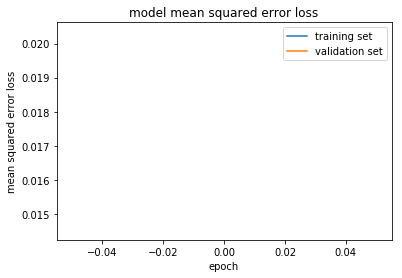

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()